## IMPORT 

In [1]:
import numpy as np
from scipy import signal
import cv2
import math
import sys
import random
# from conv import conv2d as nbconv2d
# np.set_printoptions(threshold=np.inf, linewidth = np.inf)

## BASIC FUNCTION

In [2]:
class cache:
    def __init__(self, target):
        self._value = None
        self._target = target

    def __call__(self, *args, **kwargs):
        if self._value is None:
            self._value = self._target(*args, **kwargs)
        return self._value.copy()

def qshift(m, w = 32):
    s = math.ceil(math.log2(0.5/m))
    return (round(m*(2**(w+s-1))), s)

def qscale(inl, adjust, shift, base=32):
    s = (np.sign(inl)) << (base+shift-1)
    return ((inl.astype(np.int64) * adjust + s) >> (base+shift-1))

def relu(inl, l, r):
    return inl.clip(l,r)

def relu6(inl):
    return inl.clip(0,255).astype(np.uint8)

# inl: np.uint8
# weight: np.uint8
# bias: np.int32
def conv2d(inl, *, activation, quant_adjust, bias, weight, out_offset, save=None):
    assert weight.shape[0] == bias.shape[0], f"weight and bias should have same dimesion at axis 0, found {weight.shape[0]} vs {bias.shape[0]}"
    assert inl.shape[0] == weight.shape[-1], f"weight should have same channel count as input, found {inl.shape[0]} vs {weight.shape[-1]}"
  # print("in conv")
  # print(inl[0,:10,:10])
    
    ich = inl.shape[0]
    och = bias.shape[0]
    out = np.zeros((och, *inl.shape[1:]), dtype=np.int64)
    tmp = np.zeros((och, *inl.shape[1:]), dtype=np.int64)
    
    print("weight shape: ", weight.shape)    
    print("weight : ", weight[:10,:,:,0])
    print("fm shape : ", inl.shape)
    print("fm : ", inl[:3,:10,:10])
    
    

    
    for i in range(och):
        for c in range(ich):
            # out[i] += nbconv2d(inl[c].astype(np.int32), weight[i,:,:,c].astype(np.int32), dtype=np.int32)
            out[i] += signal.convolve2d(inl[c].astype(np.int32), 
                                        np.flipud(np.fliplr(weight[i,:,:,c])).astype(np.int32), 
                                        mode='same', boundary='fill', fillvalue=0)
            #inl_tmp = np.pad(inl[c], 1, pad_with, padder=0)
            #fm_tmp = np.zeros(inl[c].shape)         
            #
            #stride = 1
            #row = out_row = 0
            ## print(inl_tmp[c].shape[0])
            #while row + 3 <= inl_tmp.shape[0]:
            #    column = out_column = 0
            #    while column + 3 <= inl_tmp.shape[0]:
            #        fm_tmp[out_row, out_column] = np.sum(weight[i, :, :, c] * inl_tmp[row: row + 3, column: column + 3])
            #        column += stride
            #        out_column += 1
            #        
            #    row += stride
            #    out_row += 1

            ## fm_tmp = signal.convolve2d(inl[c].astype(np.int32), weight[i,:,:,c].astype(np.int32), mode='same', boundary='fill', fillvalue=0)
    

        # print("out : ", out[i])
        # print("bias : ", bias.shape)
        tmp[i] = out[i]
        
        out[i] += bias[i]
    print(out.dtype)
    print("tmp : ", tmp[0:3,:10,:10])
    
    print("after bias")    
    print(out[:3,:10,:10])
 
    if save is not None:
        # pass
        np.save(save, tmp)

    if quant_adjust is not None:
        print("quant_adjust :", quant_adjust)
        out = qscale(out, *quant_adjust)
        
    print("after quantize")    
    print(out[:3,:10,:10])

    out += out_offset
    
    print("after offset")
    print(out[:3,:10,:10])

    return np.clip(out, 0, 255).astype(np.uint8)


# ina, inb: np.uint8
def add(ina, inb, quant_adjust=None):
    out = np.add(ina.astype(np.int32), inb.astype(np.int32))
    if quant_adjust is not None:
        out = qscale(out, *quant_adjust)
    return np.clip(out, 0, 255).astype(np.uint8)

# only supports CHW/CWH at this moment
def maxpooling2d(ina, ksize):
    c, h, w = ina.shape
    return ina.reshape(c, h//ksize, ksize, w//ksize, ksize).transpose(0,1,3,2,4).max((3, 4))

# assume its intputs has same scale
def concat(ina, inb, axis=-1, quant_adjust = None):
    out = np.concatenate((ina, inb), axis=axis)
    if quant_adjust is not None:
        out = qscale(out, *quant_adjust)
    return np.clip(out, 0, 255).astype(np.uint8)

def upsampling(l, dsize):
    out = cv2.resize(l.transpose(1,2,0), dsize=dsize, interpolation=cv2.INTER_NEAREST).transpose(2,0,1)     
    return cv2.resize(l.transpose(1,2,0), dsize=dsize, interpolation=cv2.INTER_NEAREST).transpose(2,0,1)

def requantize(l, f, t):
    fs, fz = f
    ts, tz = t
    return (qscale(l.astype(np.int32)-fz, *qshift(fs/ts))+tz)

def dequantize(m, z, s):
    return (m.astype(np.int32)-z) * s

def layer_save(l, fname):
    # np.save(fname, l)
    return l

class qbuffer:
    __slots__ = ('data', 'scale', 'offset')
    def __init__(self, data, scale=1, offset=0):
        self.data = data
        self.scale = scale
        self.offset = offset

def parse_quantizedata(quant):
    data = {}

    with open(quant) as f:
        f.readline()
        for l in f.readlines():
            if len(l.strip()) == 0: continue
            idx, scale, zero, path = l.strip().split(" ")
            data[int(idx, 10)] = { 'scale': float(scale), 'zero': int(zero), 'path': path, 'data': None }

    return data

def parse_model(quant, struct):
    data = parse_quantizedata(quant)
    layers = { 0: lambda inp: inp }
    outputs = []

    def load_data(idx):
        n = data[idx]['path'].split("/")[-1]
        if data[idx]['data'] is None:
            data[idx]['data'] = np.load(f"agilev3_gt/agilev3_moon224_para/{idx:03d}-{n}.txt.npy")
        return data[idx]['data']

    with open(struct) as f:
        f.readline()
        for l in f.readlines():
            if len(l.strip()) == 0: continue
            name, inl, weight, bias, out, *_ = l.strip().split("\t")
            inl = int(inl)
            out = int(out)
            print(f"{out} <- {inl}")

            if name == 'conv':
                weight = int(weight)
                bias = int(bias)

                load_data(weight)
                load_data(bias)

                i = data[inl]
                w = data[weight]
                b = data[bias]
                o = data[out]

                def make_func():
                    qadj = qshift(i['scale']*w['scale']/o['scale'])
                    # print(qadj)
                    cl = inl
                    oo = out
                    l = layers[inl]
                    wd = w['data'].astype(np.int32)-w['zero']
                    bd = b['data']
                    oz = o['zero']
                    fn = lambda inp: conv2d(l(inp),
                            activation=lambda f: relu(f, 0, 255),
                            quant_adjust=qadj,
                            weight=wd, bias=bd, out_offset=oz,
                            save=f"girl_gt_HW/con_tmp_o/layer_{oo}.npy"
                        )
                    return lambda inp: layer_save(fn(inp), f"girl_gt_HW/all_out_o/{oo}-conv.npy")

                layers[out] = cache(make_func())
                # del input_buffer, output_buffer
                
            elif name == 'cond':
                c_tim_start = time.time() 
                weight = int(weight)
                bias = int(bias)

                load_data(weight)
                load_data(bias)

                i = data[inl]
                w = data[weight]
                b = data[bias]
                o = data[out]

                def make_func():
                    qadj = qshift(i['scale']*w['scale']/o['scale'])
                    # print(qadj)
                    cl = inl
                    oo = out
                    l = layers[inl]
                    wd = w['data'].astype(np.int32)
                    bd = b['data']
                    oz = o['zero']
                    zp = w['zero']
                    fn = lambda inp: HW_conv2d(l(inp),
                            activation=lambda f: relu(f, 0, 255),
                            quant_adjust=qadj,
                            weight=wd, bias=bd, out_offset=oz, zero_point = zp,
                            save=f"girl_gt_HW/con_tmp_o/layer_{oo}.npy"
                        )
                    return lambda inp: layer_save(fn(inp), f"girl_gt_HW/all_out_o/{oo}-conv.npy")
                layers[out] = cache(make_func())
                
            elif name == 'pool':                
                def make_func():
                    cl = inl
                    oo = out
                    l = layers[cl]
                    fn = lambda inp: maxpooling2d(l(inp), 2)
                    return lambda inp: layer_save(fn(inp), f"girl_gt_HW/all_out_o/{oo}-pool.npy")
                layers[out] = cache(make_func())
                
            elif name == 'addl':
                weight = int(weight)
                def make_func():
                    cl = inl
                    oo = out
                    inas, inaz = data[inl]['scale'], data[inl]['zero']
                    inbs, inbz = data[weight]['scale'], data[weight]['zero']
                    outs, outz = data[out]['scale'], data[out]['zero']
                    qadj = qshift(inbs/outs, 32)

                    il = layers[inl]
                    jl = layers[weight]
                    fn = lambda inp: add(
                        requantize(il(inp), (inas, inaz), (inbs, inbz)),
                        jl(inp),
                        quant_adjust=qadj
                    )

                    return lambda inp: layer_save(fn(inp), f"girl_gt_HW/all_out_o/{oo}-add.npy")

                layers[out] = cache(make_func())
                
            elif name == 'rsiz':
                weight = int(weight)
                load_data(weight)
                def make_func():
                    cl = inl
                    oo = out
                    s = data[weight]['data']
                    l = layers[inl]
                    fn = lambda inp: upsampling(l(inp), dsize=tuple(s))
                    return lambda inp: layer_save(fn(inp), f"girl_gt_HW/all_out_o/{oo}-rsiz.npy")

                layers[out] = cache(make_func())
                
            elif name == 'cate':
                weight = int(weight)
                def make_func():
                    cl = inl
                    oo = out
                    inas, inaz = data[inl]['scale'], data[inl]['zero']
                    inbs, inbz = data[weight]['scale'], data[weight]['zero']
                    outs, outz = data[out]['scale'], data[out]['zero']
                    qadj = qshift(inbs/outs, 32)
                    il = layers[inl]
                    jl = layers[weight]
                    fn = lambda inp: concat(
                        requantize(il(inp), (inas, inaz), (inbs, inbz)),
                        jl(inp),
                        quant_adjust=qadj,
                        axis=0
                    )
                    return lambda inp: layer_save(fn(inp), f"girl_gt_HW/all_out_o/{oo}-concat.npy")

                layers[out] = cache(make_func())
                
            elif name == 'fmap':
                inl = int(inl)
                def make_func():
                    inls, inlz = data[inl]['scale'],data[inl]['zero']
                    l = layers[inl]
                    return lambda inp: dequantize(l(inp), inlz, inls)
                outputs.append(make_func())
                
    return outputs

def sigmoid(a):
    return 1/(1+np.exp(-a))

def reorg(feature_map, anchor, image_size, class_count):
    grid_size = feature_map.shape[0:2] # H,W
    ratio = (np.array(image_size) / grid_size)[::-1] # W,H
    anchor = anchor * grid_size / [224,224] # W,H
    feature_map = feature_map.reshape(*grid_size, 3, 5 + class_count)
    segs = np.split(feature_map, [2,4,5], axis=-1)
    box_centers, box_sizes, conf, prob = segs
    box_centers = sigmoid(box_centers)
    conf = sigmoid(conf)
    prob = sigmoid(prob)

    gx, gy = np.meshgrid(np.arange(grid_size[1]), np.arange(grid_size[0]))
    gx = gx.reshape(-1, 1)
    gy = gy.reshape(-1, 1)
    gxy = np.concatenate((gx, gy), axis=-1).reshape(*grid_size, 1, 2)

    box_centers = (box_centers + gxy) * ratio
    box_sizes = np.exp(box_sizes) * anchor * ratio

    boxes = np.concatenate((box_centers, box_sizes), axis=-1)

    return gxy, boxes.reshape(-1, 4), conf.reshape(-1, 1), prob.reshape(-1, class_count)

def py_nms(boxes, scores, max_boxes=50, iou_thresh=0.5):
    """
    Pure Python NMS baseline.

    Arguments: boxes: shape of [-1, 4], the value of '-1' means that dont know the
                      exact number of boxes
               scores: shape of [-1,]
               max_boxes: representing the maximum of boxes to be selected by non_max_suppression
               iou_thresh: representing iou_threshold for deciding to keep boxes
    """
    assert boxes.shape[1] == 4 and len(scores.shape) == 1

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= iou_thresh)[0]
        order = order[inds + 1]

    return keep[:max_boxes]
def cpu_nms(boxes, scores, num_classes, max_boxes=50, score_thresh=0.5, iou_thresh=0.5):
    """
    Perform NMS on CPU.
    Arguments:
        boxes: shape [1, 10647, 4]
        scores: shape [1, 10647, num_classes]
    """
    print('  ==== cpu mode nms  =====       \n')
    boxes = boxes.reshape(-1, 4)
    scores = scores.reshape(-1, num_classes)
    # Picked bounding boxes
    picked_boxes, picked_score, picked_label = [], [], []

    for i in range(num_classes):
        indices = np.where(scores[:,i] >= score_thresh)
        filter_boxes = boxes[indices]
        filter_scores = scores[:,i][indices]
        if len(filter_boxes) == 0: 
            continue
        # do non_max_suppression on the cpu
        indices = py_nms(filter_boxes, filter_scores,
                         max_boxes=max_boxes, iou_thresh=iou_thresh)
        picked_boxes.append(filter_boxes[indices])
        picked_score.append(filter_scores[indices])
        picked_label.append(np.ones(len(indices), dtype='int32')*i)
    if len(picked_boxes) == 0: 
        return [[],[],[]]

    boxes = np.concatenate(picked_boxes, axis=0)
    score = np.concatenate(picked_score, axis=0)
    label = np.concatenate(picked_label, axis=0)

    return boxes, score, label

def get_color_table(class_num, seed=20):
    random.seed(seed)
    color_table = {}
    for i in range(class_num):
        color_table[i] = [random.randint(0, 255) for _ in range(3)]
    # print("COLOR: ",color_table)
    return color_table

def plot_one_box(img, coord, label=None, color=None, line_thickness=None):
    '''
    coord: [x_min, y_min, x_max, y_max] format coordinates.
    img: img to plot on.
    label: str. The label name.
    color: int. color index.
    line_thickness: int. rectangle line thickness.
    '''

    color_table = get_color_table(4, seed=20)
    tl = line_thickness or int(round(0.002 * max(img.shape[0:2])))  # line thickness
    # color_table = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(coord[0]), int(coord[1])), (int(coord[2]), int(coord[3]))
    cv2.rectangle(img, c1, c2, color_table[int(label.split(":")[0])])
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=float(tl) / 3, thickness=1)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color_table[int(label.split(":")[0])], -1)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, float(tl) / 3, [0, 0, 0], thickness=tf, lineType=cv2.LINE_AA)

## HARDWARE FUNCTION

In [3]:
import numpy as np
import time
from pynq import allocate
from pynq import Overlay
import pynq.lib.dma
from pynq import Clocks
#######################沒問題######################################################
#input data imformation
def cmd_0_gen(data_load_form, fm_size, input_channel, weight_size, weight_number): 
    # string = ""
    string = (
        dec2bin(data_load_form, 2)
        + dec2bin(fm_size, 9)
        + dec2bin(input_channel, 10)
        + str(weight_size)
        + dec2bin(weight_number, 10)
    )
    # print(len(string), string)
    return string
#?
#######################沒問題#####################################################
def dec2bin(num, bit_wide): #actually return dec
    binary = bin(num)
    # print(binary)
    # print(num, end=' ')
    need = bit_wide - (len(binary) - 2)
    returnstr = ''
    for i in range(need):
        # print(0, end='')
        returnstr += '0'
    # print(binary[2:])
    returnstr += binary[2:]
    return returnstr 
##############################################################################
def HW_conv(fm, w, zero_point):  
    # fm [h, w ,c]
    # ol = Overlay("/home/xilinx/jupyter_notebooks/infernce/orig/design_1.bit")
    # ol = Overlay("/home/xilinx/jupyter_notebooks/infernce/wang_last/design_1.bit")
    ol = Overlay("/home/xilinx/jupyter_notebooks/infernce/bitstream/design_1.bit")
########
    print('load finshed')
########

    fm = np.ascontiguousarray(fm)
    fmwidth, fmheight, fmch = fm.shape

########
    if fmch < 8:
        _fmch = 8
    else:
        _fmch = fmch
    wnum, wwidth, wheight, wch = w.shape

########
    fmas8ch = np.zeros((fmwidth, fmheight, _fmch))
    fmas8ch[:, :, 0:fmch] = fm.reshape(fmwidth, fmheight, fmch)  # fm.reshape(416, 416, 3)

    if (wnum%8 != 0):
        _wnum = math.ceil(wnum/8)*8
    else: 
        _wnum = wnum

    fmsize = fmwidth * fmheight * _fmch
    wsize = _wnum * wwidth * wheight * _fmch # *8 is only for layer1, *fmch
    was8ch = np.zeros((_wnum, wwidth, wheight, _fmch))
    was8ch[0:wnum, :, :, 0:fmch] = w.transpose(0, 1, 2, 3)
###################################################################################
    # test_size = 16
    data_width = 1
    data_depth = 32+32+wsize+fmsize + 8
    test_size = data_depth * data_width
    # test_o_size = int(64/2) * data_depth
    
    if fmwidth*fmheight % 8 != 0:
        print(" state")
        ofm_size = math.ceil(fmwidth * fmheight / 8) * 8 #math.ceil 無條件進入法
        print("ofm_size :",  ofm_size)
    else:
        ofm_size = fmwidth * fmheight
    print("setting ofmsize :", ofm_size)
###########################################################
##print(":",)
    #print("////fm_data_imformation////")
    #print("_fmch:",_fmch)
    #print("fmwidth :",fmwidth)
    #print("fmheight :",fmheight)
    #print("fmsize:",fmsize)
    #print("////W_data_imformation////",)
    #print("_wnum :",_wnum) 
    #print("wheight:",wheight)
    #print("wwidth:",wwidth)
    #print("wsize:",wsize)
    #print("////other////")
    #print("data_width :",data_width)
    #print("data_depth :",data_depth)
    #print("////all////")
    
    test_o_size = int(_wnum*ofm_size*data_width) 
    
    


    # make 2 buffer 分配內存(pynq.allocate)
    input_buffer = allocate(shape=(test_size,), dtype=np.int8)
    output_buffer = allocate(shape=(test_o_size,), dtype=np.int32)
    ##################################################################
    empty = [zero_point] * 8
    
    ###########判斷w的大小
    wch_state = lambda wwidth: 0 if wwidth == 1 else (1 if wwidth == 3 else None)
    ##########
    if (wch_state(wwidth) == 1):
        w_buffer_max = 3*3*512*32
        wbuffersize = 32*3*3*512
    else:
        w_buffer_max = 3*3*256*128
        wbuffersize = 3*3*128*256

    fm_buffer_max = 112*112*64
    print("//////state 判斷//////")
    print("w_buffer_max:",w_buffer_max)
    print("fm_buffer_max:",fm_buffer_max) 
    print("fmsize:",fmsize)
    print("wsize:",wsize)
    print("wwidth",wwidth)
    print("wch_state",wch_state(wwidth))
 
    conv_stat = lambda wsize, fmsize: 0 if wsize <= w_buffer_max and fmsize <= fm_buffer_max \
    else(1 if wsize > w_buffer_max and fmsize <= fm_buffer_max else 2)
    print("conv_stat",conv_stat(wsize, fmsize))

    
    
    print(conv_stat(wsize, fmsize), fmwidth, fmch, wch_state(wwidth), _wnum)
    print("//////////////") 
    
    cmd = cmd_0_gen(conv_stat(wsize, fmsize), fmwidth, _fmch, wch_state(wwidth), _wnum)



    cmd_int = []
    print("cmd_int:",cmd_int)
    for i in range(4):
        # print(cmd[i*8:i*8+8])
        cmd_int.append(int(cmd[i*8:i*8+8], 2))
    print("cmd_int:",cmd_int)
    for i in range(4):
        # print(cmd[i:i+8])
        cmd_int.append(int(cmd[i*8:i*8+8], 2))
    print("cmd_int:",cmd_int)
    cmd_int = np.flip(cmd_int)
    print("cmd_int:",cmd_int)

    empty6 = []
    for k in range(6):
        empty6.append(empty)
        
    test = []

    test = np.append(cmd_int, cmd_int)
    test = np.append(test, cmd_int)
    test = np.append(test, empty6)
    if (wsize > wbuffersize):
        was8ch_flat = np.hsplit(was8ch.flatten(), int(wsize/wbuffersize))
        test = np.append(test, was8ch_flat[0])
    else: 
        test = np.append(test, was8ch.flatten())
    test = np.append(test, fmas8ch.flatten())
    
    np.save(f"{zero_point}_{fmch}", fmas8ch.flatten())

    if (wsize > wbuffersize):
        for z in range(len(was8ch_flat)-1):
            test = np.append(test, was8ch_flat[z+1])

    test = np.array(test, dtype=np.uint8)
    
    print(test.shape)
    print("test:",test[:128])   
    ################################

    if (data_depth % 24 !=0):
        b_c = math.ceil(data_depth / 24) 
    else:
        b_c = math.floor(data_depth / 24)
    print("b_c:",b_c)
    test_look = test
    print("test_look",test_look.shape)
    if(b_c*24 > data_depth):
        xount = b_c*24 - data_depth
        for (i) in range (xount):
            test_look = np.append(test_look,0)
    print("test_look",test_look.shape)

    test_look = test_look.reshape(b_c,24)
    www = 6146
    print("test_look:",test_look[www:www+16,:])
    print("test_look:",test_look[www+16:www+32,:])
    print("test_look:",test_look[www+32:www+48,:])
    print("test_look:",test_look[www+48:www+64,:])

    ###################################
    
    np.copyto(input_buffer, test)
    # input_buffer.sync_to_device()
    dma = ol.axi_dma_0
    #if (True):
     #   input()   
    # input()
    dma.sendchannel.transfer(input_buffer)
    dma.recvchannel.transfer(output_buffer)
    
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    
    # dma.sendchannel.stop()
    # dma.recvchannel.stop()
    # output_buffer.sync_from_device()

    # case: weights full load into IP's buffer

    fm_tiles = 1 # if features too big, = fmsize/fmbuffersize

    # print(output_buffer)

    # 8 is pe array size
    reshaped_ofm = output_buffer.reshape((int(ofm_size*_wnum/8), 8))

    ####print(reshaped_ofm.shape)
    # layer 1
    # print(reshaped_ofm.shape)
    test = np.array(np.vsplit(reshaped_ofm, int(fm_tiles*(_wnum/8))))
    ####print(test.shape)
    
    if fmwidth*fmheight % 8 != 0:    
        test = test[:,:fmwidth*fmheight,:]
    ####print(test.shape)

    for i in range(fm_tiles):
        for j in range(int(_wnum/8-1)):
            if (j == 0):
                ofm = np.hstack([test[i*int(_wnum/8)+j], test[i*int(_wnum/8)+j+1]])
            else: 
                ofm = np.hstack([ofm, test[i*int(_wnum/8)+j+1]])
        if (i == 0):
            ofm_full = ofm
        else: 
            ofm_full = np.vstack([ofm_full, ofm])
            # print(ofm_full.shape)
            
    ####print(ofm_full.shape)
    

    ofm_full = ofm_full.reshape((fmwidth, fmheight, _wnum))
    print("ofm:",ofm_full.shape)
    # np.save("ofm_full.npy", ofm_full)
    del input_buffer, output_buffer

    return ofm_full[:,:,:wnum]
    
def HW_conv2d(inl, *, activation, quant_adjust, bias, weight, out_offset, zero_point, save=None):
    
    # print(inl.shape, weight.shape)
    assert weight.shape[0] == bias.shape[0], f"weight and bias should have same dimesion at axis 0, found {weight.shape[0]} vs {bias.shape[0]}"
    assert inl.shape[0] == weight.shape[-1], f"weight should have same channel count as input, found {inl.shape[0]} vs {weight.shape[-1]}"
  # print("in conv")
  # print(inl[0,:10,:10])

    ich = inl.shape[0]
    och = bias.shape[0]
    out = np.zeros((och, *inl.shape[1:]), dtype=np.int32)
############
    ww = 0
    print("weight shape: ", weight.shape)    
    ##print("weight0 : ", weight[_wnum-8:_wnum,:,:,_fmch-2])
    ##print("weight1 : ", weight[_wnum-8:_wnum,:,:, _fmch-1])
    ##print("weight2 : ", weight[_wnum-8:_wnum,:,:, _fmch])

    print("fm shape : ", inl.shape)
    print("fm : ", inl[:3,:10,:10])
    print("zero_point: ", zero_point)
############    
    out = HW_conv(inl.transpose(1,2,0).astype(np.uint8), weight.astype(np.uint8), zero_point)
    out = out.transpose(2,0,1).astype(np.int64)
    ####print("tmp : ", out[:3, :10, :10])
    if save != None:
        np.save(save, out)
    
    # print("out", out.shape)
    # print("bias.shape :", bias.shape)
    # print(out[0][0:16])
    # sys.exit() 

   ###量化??
    for i in range(out.shape[0]):
        out[i, :, :] += bias[i]
        
    # print("after bias")    
    # print(out[:3,:10,:10])
        
 
        
    if quant_adjust is not None:
        ####print("quant_adjust :", quant_adjust)
        out = qscale(out, *quant_adjust)
        
    # print("after quantize")    
    # print(out[:3,:10,:10])

    out += out_offset 
    
    # print("after offset")    
    # print(out[:3,:10,:10])
    
    out = np.clip(out, 0, 255).astype(np.uint8)######限定out的最小最大值
    
    
    ####print("out ", out[:3, :10, :10])
    print("----------")
    return out

## DEMO

In [4]:
# software
# STRUCTURE = "structure/structure_DEMO.txt"

# hardware
STRUCTURE = "structure/structure_DEMO1.txt"

2 <- 0
61 <- 2
5 <- 61
38 <- 5
41 <- 38
66 <- 41
62 <- 66
44 <- 62
47 <- 44
50 <- 47
67 <- 50
53 <- 67
56 <- 53
68 <- 56
63 <- 68
59 <- 63
8 <- 59
11 <- 8
69 <- 11
14 <- 69
17 <- 14
70 <- 17
64 <- 70
20 <- 64
23 <- 20
26 <- 23
71 <- 26
29 <- 71
32 <- 29
72 <- 32
65 <- 72
35 <- 65
74 <- 35
77 <- 74
109 <- 77
120 <- 109
123 <- 120
126 <- 123
141 <- 126
141 <- 141
131 <- 123
144 <- 131
139 <- 144
134 <- 139
137 <- 134
80 <- 137
83 <- 80
86 <- 83
89 <- 86
142 <- 89
142 <- 142
94 <- 86
146 <- 94
140 <- 146
97 <- 140
100 <- 97
103 <- 100
106 <- 103
112 <- 106
115 <- 112
143 <- 115
143 <- 143
weight shape:  (32, 3, 3, 3)
fm shape :  (3, 224, 224)
fm :  [[[175 176 176 176 176 176 177 177 177 177]
  [176 177 177 176 176 176 177 177 177 178]
  [176 177 178 177 177 177 178 178 178 179]
  [175 177 176 177 177 177 179 179 180 180]
  [177 178 177 178 178 178 180 180 180 180]
  [176 179 179 179 179 179 180 180 180 181]
  [178 179 180 179 178 179 179 179 180 180]
  [179 180 181 180 179 180 179 179 181

ofm: (224, 224, 32)
----------
weight shape:  (64, 3, 3, 32)
fm shape :  (32, 112, 112)
fm :  [[[ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]]

 [[30 27 24 23 23 23 24 24 23 22]
  [29 28 24 23 22 23 24 24 23 23]
  [30 28 24 23 23 24 24 24 23 23]
  [31 29 24 23 23 24 24 24 24 24]
  [30 30 24 23 25 25 24 24 24 24]
  [29 28 25 24 25 26 24 24 24 24]
  [25 25 26 24 24 24 24 24 24 24]
  [26 26 26 24 24 24 24 24 24 24]
  [28 27 25 23 24 24 24 24 24 24]
  [29 27 24 23 24 24 24 23 24 24]]

 [[ 5  6  6  7  7  7  8  8  8  8]
  [ 5  6  6  7  7  8  8  8  8  8]
  [ 6  7  7  7  8  8  8  8  8  8]
  [ 6  7  7  7  8  9  9  9  9  9]
  [ 6  7  8  9 10 10  9  9  9  9]
  [ 7  7  8  9  9 10  9  9  9  9]
  [ 7  8  8  9  9 

ofm: (112, 112, 64)
----------
weight shape:  (32, 1, 1, 64)
fm shape :  (64, 112, 112)
fm :  [[[ 0 18 18 19 19 19 19 19 18 19]
  [ 0 43 40 40 41 40 39 38 38 39]
  [ 0 29 25 25 24 26 26 26 26 26]
  [ 0 28 24 24 25 26 25 25 25 25]
  [ 0 28 26 26 27 25 24 25 25 25]
  [ 0 27 26 26 25 23 25 26 25 25]
  [ 0 27 25 25 26 25 24 25 25 24]
  [ 0 27 25 25 26 25 24 25 25 24]
  [ 0 28 25 25 25 25 24 25 25 25]
  [ 0 28 25 24 24 25 24 25 25 26]]

 [[ 0  0  0  0  0  0  0  0  0  0]
  [ 0 40 31 31 31 31 31 32 30 30]
  [ 0 26 15 15 15 15 16 16 15 15]
  [ 0 27 16 15 15 15 16 16 15 14]
  [ 0 26 16 16 16 16 15 16 16 15]
  [ 0 25 15 15 15 15 15 16 15 16]
  [ 0 26 14 15 16 15 15 16 15 15]
  [ 0 26 14 14 16 15 15 16 16 15]
  [ 0 26 14 14 15 16 15 15 16 15]
  [ 0 26 15 14 14 16 15 15 15 16]]

 [[ 0  0  0  0  0  0  0  0  0  0]
  [12 24 26 24 25 25 25 24 25 25]
  [ 9 22 26 25 25 25 25 24 25 26]
  [ 9 22 27 27 26 25 25 25 24 24]
  [ 9 22 25 25 24 25 26 25 25 26]
  [ 9 24 25 25 25 24 26 25 25 25]
  [10 23 25 26 26 

load finshed
setting ofmsize : 12544
//////state 判斷//////
w_buffer_max: 147456
fm_buffer_max: 802816
fmsize: 401408
wsize: 18432
wwidth 3
wch_state 1
conv_stat 0
0 112 32 1 64
//////////////
cmd_int: []
cmd_int: [14, 1, 4, 64]
cmd_int: [14, 1, 4, 64, 14, 1, 4, 64]
cmd_int: [64  4  1 14 64  4  1 14]
(419912,)
test: [ 64   4   1  14  64   4   1  14  64   4   1  14  64   4   1  14  64   4
   1  14  64   4   1  14 139 139 139 139 139 139 139 139 139 139 139 139
 139 139 139 139 139 139 139 139 139 139 139 139 139 139 139 139 139 139
 139 139 139 139 139 139 139 139 139 139 139 139 139 139 139 139 139 139
 121 161 141 171 181 116 180 121 139 123 182 152 116 147 149 166 137 149
 130 143 136 138 119 147 176 139 122 109 116 100 153 141 154 145 160 160
 172 136 164 124 152 149 139 164 122 167 143 157 191 135 173 122 150 148
 137 153]
b_c: 17497
test_look (419912,)
test_look (419928,)
test_look: [[  0   0  17   0   0   0  12  15  17  88   0  63   0   0   0  82  34  41
   94   0   0  34   0   0]


load finshed
setting ofmsize : 3136
//////state 判斷//////
w_buffer_max: 147456
fm_buffer_max: 802816
fmsize: 200704
wsize: 73728
wwidth 3
wch_state 1
conv_stat 0
0 56 64 1 128
//////////////
cmd_int: []
cmd_int: [7, 2, 4, 128]
cmd_int: [7, 2, 4, 128, 7, 2, 4, 128]
cmd_int: [128   4   2   7 128   4   2   7]
(274504,)
test: [128   4   2   7 128   4   2   7 128   4   2   7 128   4   2   7 128   4
   2   7 128   4   2   7 132 132 132 132 132 132 132 132 132 132 132 132
 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132
 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132
 133 129 131 128 134 127 130 135 134 132 126 135 130 136 132 139 138 134
 131 130 130 117 132 132 135 129 130 124 137 133 133 147 133 129 136 135
 127 134 134 127 126 119 134 131 129 134 119 126 129 130 128 129 129 131
 124 133]
b_c: 11438
test_look (274504,)
test_look (274512,)
test_look: [[ 10  14 146  94  32   0 101   0  89  24   0 151  53  91 255 253  53  64
   41   0   0  48 14

load finshed
setting ofmsize : 3136
//////state 判斷//////
w_buffer_max: 294912
fm_buffer_max: 802816
fmsize: 401408
wsize: 8192
wwidth 1
wch_state 0
conv_stat 0
0 56 128 0 64
//////////////
cmd_int: []
cmd_int: [7, 4, 0, 64]
cmd_int: [7, 4, 0, 64, 7, 4, 0, 64]
cmd_int: [64  0  4  7 64  0  4  7]
(409672,)
test: [ 64   0   4   7  64   0   4   7  64   0   4   7  64   0   4   7  64   0
   4   7  64   0   4   7 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 157 173 157 107 148 173 167 180 167 166 133 183 192 189 169 119 160 134
 163 128 203 176 190 197 145 160 190 148 149 115 144 120 168 165 129 181
 150 146 145 160 147 172 148 153 145 156 153 167 175 150 144 105 211 139
 126 140]
b_c: 17070
test_look (409672,)
test_look (409680,)
test_look: [[ 39   0   0   0  33  69   0  17  38   0  42   0   0   2  72   0  44   0
    2  14  18   8  68  39]
 [  0

ofm: (56, 56, 128)
----------
weight shape:  (64, 1, 1, 128)
fm shape :  (128, 56, 56)
fm :  [[[116  90 105  89  87  91  85  87  91  89]
  [ 74  30  76  37  46  43  43  41  47  45]
  [ 90  17  18   9  16  13  15  17  17  16]
  [ 80  20  14  11  18  20  19  17  17  16]
  [ 82  20  17  16  21  16  18  18  24  22]
  [ 81  14  12  16  22  23  23  17  17  17]
  [ 81  20  26  21  16  17  19  14  17  21]
  [ 81  20  18  21  17  19  20  26  23  21]
  [ 77  18  13   4  14  18  15  14  16  16]
  [ 76  15  13  11  19  24  20  16  18  18]]

 [[ 14  26  58  72  69  68  66  65  58  62]
  [  0   0  18  41  36  21  27  37  27  26]
  [  0   0   6   9  14  11  16  22  15  19]
  [  0   0   9  10  15  19  30  23  27  27]
  [  0   0   7  13  18  16  31  26  39  31]
  [  0   0  15  22  24  14  31  28  33  23]
  [  0   0  29  13   7  12  21  30   8  13]
  [  0   0  27  15  18  24  35  41  10  15]
  [  0   0  22  17  14  25  30  34  32  18]
  [  0   0  18  35  18   8   9  25  44  39]]

 [[ 85  74  86  79  75 

ofm: (56, 56, 64)
----------
weight shape:  (128, 3, 3, 64)
fm shape :  (64, 56, 56)
fm :  [[[ 61  64  72  63  67  57  69  67  64  63]
  [ 69  24   0  21  14   0   9  25   1  20]
  [ 47   3   0   0   0   0   0   0   0   0]
  [ 38   0   0   0   0   0   0   0   0   0]
  [ 42   0   0   0   0   0   0   0   0   0]
  [ 47   0   0   0   0   0   0   0   0   0]
  [ 39   0   0   0   0   0   0   0   0   0]
  [ 38   0   0   0   0   0   0   0   0   0]
  [ 37   0   0   0   0   0   0   0   0   0]
  [ 42   0   0   0   0   0   0   1   0   0]]

 [[ 71 101 107  92  94  86  90 102  91  93]
  [112  48  22  21  26  20  14  18  21  14]
  [120  14   6  27  36  29  32  23  32  22]
  [101  14  12   9  15  15  18  13  15  10]
  [ 91  27  24   4  12   0   0   4   0   4]
  [ 98  27  15   0  16  23  20  11   0  17]
  [ 92   5  29   1  11  29   9  11   0  11]
  [ 88   8  11   0   0   3   3  18  11  10]
  [ 89  21  20  22   8   4   7  10  29   8]
  [101  29  13  35  14   0   0   0  18   0]]

 [[  0  17   2   0   0   

ofm: (56, 56, 128)
----------
weight shape:  (256, 3, 3, 128)
fm shape :  (128, 28, 28)
fm :  [[[225 178 130 131 142 159 132 137 151 119]
  [150  44  42  52  65  71  55  45  59  26]
  [139  34  35  39  25  59  62  49  43  42]
  [136  55  27  44  33  59  46  30  24  43]
  [131  30  27  25  19  28  34  27  19  89]
  [146  32  45  60  37  75  70  21  23  28]
  [149  21  21  20  82  56  13   0  12  17]
  [127  36  32  19  71 114 105  22  17  12]
  [143  19  22  29   6  31  54  30  44   0]
  [118  41  25  19  36  41 104  25   0   0]]

 [[166 175 145 145 132 155 160 155 143 143]
  [ 36  56  62  85  86  87  69  68  84  47]
  [ 67  53  79 112 116 109 134 109  95  20]
  [ 81 114  86  97  84 109  98 129  72  35]
  [ 56 103  60 117 132  97  90 117  78 103]
  [ 67 100 114  73  77 118  84  53  84  33]
  [ 64  66  97  67  42 133  39  14  94   8]
  [ 88  84  82  55   0  52  56   0  61  30]
  [ 67  82  39  73  59 120  68   0  63  73]
  [ 61  96  39 189  38   0  36   0 119 136]]

 [[170 149 164 167 171

ofm: (28, 28, 256)
----------
weight shape:  (128, 1, 1, 256)
fm shape :  (256, 28, 28)
fm :  [[[ 0 15 44 54 45 39 34 30 38 57]
  [ 0  0  0  0  0  0  0  0  0 15]
  [ 0  0  0  0  0  0  0 16  0  0]
  [ 0  0  0  2  0  3  0 12  6  0]
  [ 0  0  6  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  1  0  0  0  0  5  0  0]
  [ 0  0 25 43  0  0  0 36  0 22]
  [ 0  0  1 30  0  0  0  0  0  0]]

 [[ 6 33 48 45 45 43 40 40 45 45]
  [ 0  0  0  3  2  5  0  0  0  3]
  [ 0  0  7 13 15 27 19 11  0  0]
  [ 0  7  8  1 14 13 12  0  9  4]
  [ 0  0 12 27 36 36 36 11 10  2]
  [ 0  0  3 10 35 47 41  4  0  0]
  [ 0  0  0  2 35 46 45 11  0  0]
  [ 3  2  4 14 44  2  0  0  0  0]
  [ 0  8  5 10  0  0  0  0  0  0]
  [ 0  0 19 19  0  0  0  0  0  0]]

 [[88 39 40 47 48 44 44 51 36 53]
  [39  0  0  2  2  0  0  0  0  0]
  [56  0  8  9  7  0  0  0  0  0]
  [67  8  1  5  0  5  0  0  0  0]
  [62 18  5  0 14 18  2  0  0  0]
  [58  0  0  2  0  0  0  0  0  0]
  [64  0  2  0 22 

load finshed
setting ofmsize : 784
//////state 判斷//////
w_buffer_max: 147456
fm_buffer_max: 802816
fmsize: 100352
wsize: 294912
wwidth 3
wch_state 1
conv_stat 1
1 28 128 1 256
//////////////
cmd_int: []
cmd_int: [67, 132, 5, 0]
cmd_int: [67, 132, 5, 0, 67, 132, 5, 0]
cmd_int: [  0   5 132  67   0   5 132  67]
(395336,)
test: [  0   5 132  67   0   5 132  67   0   5 132  67   0   5 132  67   0   5
 132  67   0   5 132  67 112 112 112 112 112 112 112 112 112 112 112 112
 112 112 112 112 112 112 112 112 112 112 112 112 112 112 112 112 112 112
 112 112 112 112 112 112 112 112 112 112 112 112 112 112 112 112 112 112
 105 146 115 146 127 147 114 105  65 116  87  87 117 111 106 112 130 115
  86  91  92 107 103 100  89 124 161 130 108  97 122  97 133 113 124 117
  94  81 113 106 132 128 128 105 126 123 101 115 103  89 115 116 144 108
 104 109]
b_c: 16473
test_look (395336,)
test_look (395352,)
test_look: [[ 93  94  99  67  74 128 130 135  89 118 106 122 105 136 139 107  70  87
  116 124  77 12

load finshed
setting ofmsize : 784
//////state 判斷//////
w_buffer_max: 294912
fm_buffer_max: 802816
fmsize: 200704
wsize: 32768
wwidth 1
wch_state 0
conv_stat 0
0 28 256 0 128
//////////////
cmd_int: []
cmd_int: [3, 136, 0, 128]
cmd_int: [3, 136, 0, 128, 3, 136, 0, 128]
cmd_int: [128   0 136   3 128   0 136   3]
(233544,)
test: [128   0 136   3 128   0 136   3 128   0 136   3 128   0 136   3 128   0
 136   3 128   0 136   3 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 146 199  84 103 113  92  83  63 112  81 139 132 113 113  98 112 120 132
 126  94  86 132  73  68 145 109 142  98 120  90 138 190  69  76  93  98
  95 143  79 119  55 101 115  99  49 132  87 147  99 121 109 114  92 104
 118 104]
b_c: 9731
test_look (233544,)
test_look (233544,)
test_look: [[ 90  75   0   0  56   0  35   0   5  17   0   0   0   4   0   6   0  31
   25  62   0  

load finshed
setting ofmsize : 784
//////state 判斷//////
w_buffer_max: 147456
fm_buffer_max: 802816
fmsize: 100352
wsize: 294912
wwidth 3
wch_state 1
conv_stat 1
1 28 128 1 256
//////////////
cmd_int: []
cmd_int: [67, 132, 5, 0]
cmd_int: [67, 132, 5, 0, 67, 132, 5, 0]
cmd_int: [  0   5 132  67   0   5 132  67]
(395336,)
test: [  0   5 132  67   0   5 132  67   0   5 132  67   0   5 132  67   0   5
 132  67   0   5 132  67 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 110 128 102  91 107 141 100  92  74 110  98 112 130  92 112  62  80  94
 120  94  83 125 111  91  91  91 104 112  92  80  98 107  86  76  83  97
  99 125  83 113  84  81  93 112 124  89  87 119  95  77  80 104 102  91
  86  97]
b_c: 16473
test_look (395336,)
test_look (395352,)
test_look: [[ 83 107  72 110 127 103 102  88 110 133  61  99  70  81  89 126 106  93
   93 102 102  9

load finshed
 state
ofm_size : 200
setting ofmsize : 200
//////state 判斷//////
w_buffer_max: 147456
fm_buffer_max: 802816
fmsize: 50176
wsize: 1179648
wwidth 3
wch_state 1
conv_stat 1
1 14 256 1 512
//////////////
cmd_int: []
cmd_int: [65, 200, 6, 0]
cmd_int: [65, 200, 6, 0, 65, 200, 6, 0]
cmd_int: [  0   6 200  65   0   6 200  65]
(1229896,)
test: [  0   6 200  65   0   6 200  65   0   6 200  65   0   6 200  65   0   6
 200  65   0   6 200  65 107 107 107 107 107 107 107 107 107 107 107 107
 107 107 107 107 107 107 107 107 107 107 107 107 107 107 107 107 107 107
 107 107 107 107 107 107 107 107 107 107 107 107 107 107 107 107 107 107
 118  98 109 105 122 103 144 102 120 131 114  93  95 119 111  77 108  98
 109 125 118  98 120 106  98 104  99 118 102  78 108 106 121  90 120 114
 141 115 136 106 101  95 111  98  99 113 120 106 115 118 106 115 100  87
 116 111]
b_c: 51246
test_look (1229896,)
test_look (1229904,)
test_look: [[122  79  95  99 104 115 126 118 131  82 105  93  90 102 114 105

load finshed
 state
ofm_size : 200
setting ofmsize : 200
//////state 判斷//////
w_buffer_max: 294912
fm_buffer_max: 802816
fmsize: 100352
wsize: 131072
wwidth 1
wch_state 0
conv_stat 0
0 14 512 0 256
//////////////
cmd_int: []
cmd_int: [1, 208, 1, 0]
cmd_int: [1, 208, 1, 0, 1, 208, 1, 0]
cmd_int: [  0   1 208   1   0   1 208   1]
(231496,)
test: [  0   1 208   1   0   1 208   1   0   1 208   1   0   1 208   1   0   1
 208   1   0   1 208   1  96  96  96  96  96  96  96  96  96  96  96  96
  96  96  96  96  96  96  96  96  96  96  96  96  96  96  96  96  96  96
  96  96  96  96  96  96  96  96  96  96  96  96  96  96  96  96  96  96
 113  72 115  89  99 101  48 126 105  87  96 120  66  67  86 112 103 119
  71 130  85  60  94  63  54  65 119  73 102  69  99 111 104  36  61  76
  57 100  92  99  73  78  61  75  87 105 101 108 123 100 104  79 108  81
  81 126]
b_c: 9646
test_look (231496,)
test_look (231504,)
test_look: [[ 27   0   0   0   0   0  49   0   1  13   0   0   0   0   0  28   0   

load finshed
 state
ofm_size : 200
setting ofmsize : 200
//////state 判斷//////
w_buffer_max: 147456
fm_buffer_max: 802816
fmsize: 50176
wsize: 1179648
wwidth 3
wch_state 1
conv_stat 1
1 14 256 1 512
//////////////
cmd_int: []
cmd_int: [65, 200, 6, 0]
cmd_int: [65, 200, 6, 0, 65, 200, 6, 0]
cmd_int: [  0   6 200  65   0   6 200  65]
(1229896,)
test: [  0   6 200  65   0   6 200  65   0   6 200  65   0   6 200  65   0   6
 200  65   0   6 200  65  99  99  99  99  99  99  99  99  99  99  99  99
  99  99  99  99  99  99  99  99  99  99  99  99  99  99  99  99  99  99
  99  99  99  99  99  99  99  99  99  99  99  99  99  99  99  99  99  99
 130  71 124  86  95  99  81  74 125 115 104  72 106 118  86 102 121 133
 104 100  87  72 126 100 117  94 120  94 109  68 125  88 105  68  98 129
 125  94  84  91  90  83  88 113  62  80  91  95 101  76  77 115 109 116
 119  84]
b_c: 51246
test_look (1229896,)
test_look (1229904,)
test_look: [[ 97  77  94  91  79  74  93 103 116 104  98 101 103 129  86 138

load finshed
 state
ofm_size : 200
setting ofmsize : 200
//////state 判斷//////
w_buffer_max: 294912
fm_buffer_max: 802816
fmsize: 100352
wsize: 131072
wwidth 1
wch_state 0
conv_stat 0
0 14 512 0 256
//////////////
cmd_int: []
cmd_int: [1, 208, 1, 0]
cmd_int: [1, 208, 1, 0, 1, 208, 1, 0]
cmd_int: [  0   1 208   1   0   1 208   1]
(231496,)
test: [  0   1 208   1   0   1 208   1   0   1 208   1   0   1 208   1   0   1
 208   1   0   1 208   1 138 138 138 138 138 138 138 138 138 138 138 138
 138 138 138 138 138 138 138 138 138 138 138 138 138 138 138 138 138 138
 138 138 138 138 138 138 138 138 138 138 138 138 138 138 138 138 138 138
 154 183 157 163 131 166  99 114 133 166 133 132 136 110 190 109 136 118
 115 141 145 155 144 121 131 131 144 144 165  89 120 104 136 173 119 111
 129 123 145 133 131 131 107 136 124 138 177 108 132 117 132 145 143 136
 164 129]
b_c: 9646
test_look (231496,)
test_look (231504,)
test_look: [[ 28   0   0   0   0   0  50   0  12  14   0   0   8   0   0  29   0  1

load finshed
 state
ofm_size : 200
setting ofmsize : 200
//////state 判斷//////
w_buffer_max: 147456
fm_buffer_max: 802816
fmsize: 50176
wsize: 1179648
wwidth 3
wch_state 1
conv_stat 1
1 14 256 1 512
//////////////
cmd_int: []
cmd_int: [65, 200, 6, 0]
cmd_int: [65, 200, 6, 0, 65, 200, 6, 0]
cmd_int: [  0   6 200  65   0   6 200  65]
(1229896,)
test: [  0   6 200  65   0   6 200  65   0   6 200  65   0   6 200  65   0   6
 200  65   0   6 200  65 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
  93  80 123  91  86 120 131  87 114 107  98  81 123  92 120  90  70 124
  75  77  95  93 108 128  92  85  95  97  79 114  83  80  97  89  97  93
  96 100 108  91  78  86  77 100  96  77  99  75  92  79 107 114 106  72
  94  90]
b_c: 51246
test_look (1229896,)
test_look (1229904,)
test_look: [[ 84  88 103  98 120  82 119 125 121 126  87 110 107  69 106 130

load finshed
 state
ofm_size : 56
setting ofmsize : 56
//////state 判斷//////
w_buffer_max: 147456
fm_buffer_max: 802816
fmsize: 25088
wsize: 2359296
wwidth 3
wch_state 1
conv_stat 1
1 7 512 1 512
//////////////
cmd_int: []
cmd_int: [64, 240, 6, 0]
cmd_int: [64, 240, 6, 0, 64, 240, 6, 0]
cmd_int: [  0   6 240  64   0   6 240  64]
(2384456,)
test: [  0   6 240  64   0   6 240  64   0   6 240  64   0   6 240  64   0   6
 240  64   0   6 240  64 122 122 122 122 122 122 122 122 122 122 122 122
 122 122 122 122 122 122 122 122 122 122 122 122 122 122 122 122 122 122
 122 122 122 122 122 122 122 122 122 122 122 122 122 122 122 122 122 122
 138 107 163 113 134 145 142  95 137  77 151 108 113 124 165  90 129  97
 125 129 122 123 133 123 141 143 120 153 119 107 124 140 117 144 113 143
  98 139 114 130 111 106 100 149 112 149 166  96 112 149 108 134 156 142
 102  89]
b_c: 99353
test_look (2384456,)
test_look (2384472,)
test_look: [[144 103 147 120 137 126 140 120 130 125 119 125 152 122 110 108 10

----------
weight shape:  (512, 3, 3, 256)
fm shape :  (256, 7, 7)
fm :  [[[51 33  0 19 36  0 65]
  [ 2  0  0  0 22  0  0]
  [ 0  0  0  0  3  1  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  5 14  0  0  0]
  [ 0  0  0  0  1  0  0]
  [39  0 34 55 43 57  0]]

 [[ 0  0 12 14  5  0 94]
  [27  1  0  0  0  0  0]
  [ 0 11 11  0  0  0  0]
  [ 0 17  4  0  0  0  0]
  [ 0  1  6  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0 27  0  0]]

 [[25 62 35  0  0 36 62]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0 11]
  [ 0  5  0  0  0  0 18]
  [ 0  0  0 11  2  0  0]
  [ 0  0  0 24 38 36 43]]]
zero_point:  127
load finshed
 state
ofm_size : 56
setting ofmsize : 56
//////state 判斷//////
w_buffer_max: 147456
fm_buffer_max: 802816
fmsize: 12544
wsize: 1179648
wwidth 3
wch_state 1
conv_stat 1
1 7 256 1 512
//////////////
cmd_int: []
cmd_int: [64, 232, 6, 0]
cmd_int: [64, 232, 6, 0, 64, 232, 6, 0]
cmd_int: [  0   6 232  64   0   6 232  64]
(1192264,)
test: [  0   6 232  64   0   6 232  64

load finshed
 state
ofm_size : 56
setting ofmsize : 56
//////state 判斷//////
w_buffer_max: 294912
fm_buffer_max: 802816
fmsize: 25088
wsize: 131072
wwidth 1
wch_state 0
conv_stat 0
0 7 512 0 256
//////////////
cmd_int: []
cmd_int: [0, 240, 1, 0]
cmd_int: [0, 240, 1, 0, 0, 240, 1, 0]
cmd_int: [  0   1 240   0   0   1 240   0]
(156232,)
test: [  0   1 240   0   0   1 240   0   0   1 240   0   0   1 240   0   0   1
 240   0   0   1 240   0 110 110 110 110 110 110 110 110 110 110 110 110
 110 110 110 110 110 110 110 110 110 110 110 110 110 110 110 110 110 110
 110 110 110 110 110 110 110 110 110 110 110 110 110 110 110 110 110 110
 115 138  79 102 123 127 103 102  92 149 162 106 117  95  89 107 131 122
 120  88 127  85 138  69 129 115 112  45  79 101 170 107 142 184  58 118
 143 129 164 103  74 134 138 110 102  80 110  81 120  68 144  75  92 109
 142  86]
b_c: 6510
test_look (156232,)
test_look (156240,)
test_look: [[ 0  0 32  0  0  0  0  0  0  0 38  0 52  0  0  0  0 13  0  0 22 11  0  0]
 

ofm: (7, 7, 512)
----------
weight shape:  (256, 1, 1, 512)
fm shape :  (512, 7, 7)
fm :  [[[  0   0   0   0   0   0   0]
  [  5   0   0   0   0  10   0]
  [ 60  84  55  22  30  32  14]
  [ 76  85  71   7   5  10   1]
  [ 37  53  61  58  30  28  30]
  [ 20  58  51  61  36  24  56]
  [ 34  29  36  45  23  43  37]]

 [[  0  12   0   0   0   0  26]
  [  0   0   6  50  75  74  85]
  [  0   0   0  56  37  75  47]
  [ 10  34   0   0   0  41  61]
  [ 50  75   0   0  24  45  27]
  [  0   0   0  21  48  84  79]
  [  0   0   3  50  55  60  82]]

 [[146  79  48  34  40  51  53]
  [  0   0   0   0   0   0   0]
  [ 34   0   0   0   0   0   0]
  [ 12   0   0  15   2   0   0]
  [  1   0   0   0   0   0   0]
  [  0   0   0   1   0   0   0]
  [  9  21  19  30  30  18  34]]]
zero_point:  124
load finshed
 state
ofm_size : 56
setting ofmsize : 56
//////state 判斷//////
w_buffer_max: 294912
fm_buffer_max: 802816
fmsize: 25088
wsize: 131072
wwidth 1
wch_state 0
conv_stat 0
0 7 512 0 256
//////////////
cmd_in

----------
weight shape:  (512, 3, 3, 256)
fm shape :  (256, 7, 7)
fm :  [[[ 79  45  13  23   2   0  47]
  [ 26  27   0   0   0   5  60]
  [  0   0   0   0   0   4   2]
  [  0   0   0  21   2   9   0]
  [  0   0   0   0   0  31  15]
  [  0   0   2   8   0   0  28]
  [  0   0   4  50  46  34  47]]

 [[127  20  13   0   0   0   0]
  [ 45   0   0   0   0   0   0]
  [  8   8   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [ 44  24  43  53  36   2   2]]

 [[123 130  50  35  18   3  34]
  [ 94  60  23  17  13  23  17]
  [  0   0   6  12   2   0   0]
  [  0   0  13  25   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   6]]]
zero_point:  133
load finshed
 state
ofm_size : 56
setting ofmsize : 56
//////state 判斷//////
w_buffer_max: 147456
fm_buffer_max: 802816
fmsize: 12544
wsize: 1179648
wwidth 3
wch_state 1
conv_stat 1
1 7 256 1 512
//////////////
cmd_int: []
cmd_int: [

ofm: (7, 7, 512)
----------
weight shape:  (27, 1, 1, 512)
fm shape :  (512, 7, 7)
fm :  [[[  0   0  26  22  34  38  28]
  [  0   0   0   0   0   4   7]
  [  0   0   2  12  36  28  18]
  [ 30   0  29  35  70  69  31]
  [ 52  11  33  28  76  83  37]
  [ 35   0   4   0   3   2   9]
  [ 29  27  18   0   0  14  17]]

 [[ 63  73  59  39  29  14   0]
  [141 131  99  35  38  34  42]
  [ 77 100 104  19  58  22  23]
  [  6   8   7   0   0   0   6]
  [  0   0   0   0   0   0   9]
  [  3   0   0   0  25  52  46]
  [  3   0   0  29  51 118 105]]

 [[  0   0  13  41  12   0   0]
  [  0   0   0  37  11  26   6]
  [  0   7  18  52   0  21  23]
  [ 20  42  23  23   0  19  27]
  [ 32  55  26  23   0  10  26]
  [ 23  83  83  79  17   0   5]
  [ 19  59  60  26   0   0  18]]]
zero_point:  131
load finshed
 state
ofm_size : 56
setting ofmsize : 56
//////state 判斷//////
w_buffer_max: 294912
fm_buffer_max: 802816
fmsize: 25088
wsize: 16384
wwidth 1
wch_state 0
conv_stat 0
0 7 512 0 32
//////////////
cmd_int: 

----------
weight shape:  (512, 3, 3, 256)
fm shape :  (256, 14, 14)
fm :  [[[  0   0   0   0  52  45  58  18   0   0]
  [  0  22   0  27  79  26  70  78  21  22]
  [  0   0   0  13  46  26  10  11   0   0]
  [  0   0   0   0  24   0   0   0   0  11]
  [  0   0  18  18  14   0   0   0   0   8]
  [  0   0  57  63   0   2  22   0   0  12]
  [  0   0  46  46   3   0  37  31  16   8]
  [  0   0  10   0   0   0  38  23   0   0]
  [ 13   0   0   0   0   8  33   0   0   5]
  [ 12   0   6   0   0   0   4   0   0   0]]

 [[  0   0   0   0   4   9   0   0   0   0]
  [  0   0   0   0   3   0   0   0   0   0]
  [  0   0  20  16   0   0   0   0  17  21]
  [  0   0  20   2   0   0   0   0   0   0]
  [  0  39   0   0   0  26   0   0   0  32]
  [ 44   0   0   0   0  54  48   0   0  68]
  [ 27   0   0   0   0  18  14   0   0  38]
  [  0   0   1   0   2  35  15   0  10   0]
  [  2  14  37  26  53  86  41  35  44  12]
  [ 45  22  26  34  54  43  14  25  20  38]]

 [[ 94 116  20  40  30   0   0  10   9  1

ofm: (14, 14, 512)
----------
weight shape:  (256, 1, 1, 512)
fm shape :  (512, 14, 14)
fm :  [[[ 57 107  72   5   0   0   0   0   0   0]
  [ 72  88  62   0   0   0   2   0   0  10]
  [ 26  15   4   6   8   0  13   6   0   0]
  [  0   0   0   0   0   0  15  12   0   0]
  [  0   0   0   0   0   0   4   4   6   0]
  [  0   0   0   0   0   0   0  36  33   0]
  [  0   0   0   1   0   0  16  62  51   0]
  [  0   0   0  37  30  22  26  41  33   6]
  [  0   0  11  41  41  29  31  19  16  24]
  [  0   0   2  42  28  26  23  11   9  24]]

 [[ 36  65  56  25  11  16   0   0  16   8]
  [  0   5  28   0   0   0   0   0   0   0]
  [  0   9  27   0   0   0   0   0  14   0]
  [  7  14  11   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0]
  [  2   0   0   0   0   0   0   0   0   0]
  [  0   0  22   0   0   0   0   0   0   0]
  [  0   0  14   2   0   0   0   0   0   0]
  [  0   0   9  10   0   0   0   0   0   0]
  [  0  21  13   5   0   0   0   0   0   0]]

 [[  0   0   0   0   0

load finshed
 state
ofm_size : 200
setting ofmsize : 200
//////state 判斷//////
w_buffer_max: 147456
fm_buffer_max: 802816
fmsize: 50176
wsize: 1179648
wwidth 3
wch_state 1
conv_stat 1
1 14 256 1 512
//////////////
cmd_int: []
cmd_int: [65, 200, 6, 0]
cmd_int: [65, 200, 6, 0, 65, 200, 6, 0]
cmd_int: [  0   6 200  65   0   6 200  65]
(1229896,)
test: [  0   6 200  65   0   6 200  65   0   6 200  65   0   6 200  65   0   6
 200  65   0   6 200  65 124 124 124 124 124 124 124 124 124 124 124 124
 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124
 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124
 146 140  86 122 154  81 132 132 156 174 146 145 159 129 127 163 167 149
 145 131 106 108 141 103 108 122 130 151 157 118  84 146 113 129 130  92
 121 151 149 125 105 117 155 113 118 110 137  85  94 110 103 109 165 105
  92 150]
b_c: 51246
test_look (1229896,)
test_look (1229904,)
test_look: [[125 159 137 136 143 154 113 102 115 151  92 137 114 183 145  83

load finshed
 state
ofm_size : 200
setting ofmsize : 200
//////state 判斷//////
w_buffer_max: 294912
fm_buffer_max: 802816
fmsize: 100352
wsize: 131072
wwidth 1
wch_state 0
conv_stat 0
0 14 512 0 256
//////////////
cmd_int: []
cmd_int: [1, 208, 1, 0]
cmd_int: [1, 208, 1, 0, 1, 208, 1, 0]
cmd_int: [  0   1 208   1   0   1 208   1]
(231496,)
test: [  0   1 208   1   0   1 208   1   0   1 208   1   0   1 208   1   0   1
 208   1   0   1 208   1 135 135 135 135 135 135 135 135 135 135 135 135
 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135
 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135
 114 113 126 167 125 171 129 160 135 123 143 147 167 140 144 130 128 111
 123 169 123 115 145 125 114 137 148 159 131 147 119 136 159 148 122 151
 155 128 144 131 139 168 114 136 104 157 145 157 182 130 140 123 106 126
 138 134]
b_c: 9646
test_look (231496,)
test_look (231504,)
test_look: [[57 25  0 14  0 15  0 12 25  0 16 66 13  0 46 18  0 41 51  0 33 11 15 3

ofm: (14, 14, 512)
----------
weight shape:  (27, 1, 1, 512)
fm shape :  (512, 14, 14)
fm :  [[[ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  3 16  0  0  0  0  0  0]
  [ 0 20 39 41 13  0 13  0  0  4]
  [12  3 21 24  0  0 12  0  0  0]
  [20  0  8  4  0  0  0  0  0  0]
  [ 3  0  8  7  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]]

 [[ 0  0  0  0  0  6 17 11  2  4]
  [ 0  0  0  0 10 14 24  9  0  9]
  [ 0  0  0  0  0  9 26  9  0  1]
  [ 0  0  7 17  1  4 30 32  0  0]
  [ 0  0 34 26  0  1 28 54 14  4]
  [ 0  0 50 51  0  0  6 31 17  5]
  [ 0  0 36 70  0  0  0 27 22 17]
  [ 0  0 10 54  0  0 15 32 16  1]
  [ 0  0  0 22  0  0  8 12  7  0]
  [ 0  0 10 40 18 13 28 19 22 21]]

 [[21 59 53 31 19 16 31 40 49 31]
  [ 0  0  4  0  0  0 12 11  7  0]
  [ 0  0  0  0  0  0  0  0  0  2]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  

----------
weight shape:  (256, 3, 3, 128)
fm shape :  (128, 28, 28)
fm :  [[[  0   0   0   0   0   0   0   0   0   0]
  [  5   0   0   0   0   0   0   0   0   0]
  [ 78   0   6   3   0   0  26  44  26   0]
  [ 79  16  15   5   0   0  30  47   8   0]
  [ 81   6  20  35  46  36  41  68   6  26]
  [ 91   7  20  25  19  11  23  81   0  26]
  [ 57   0  39  28   0   0   0  39   0   0]
  [ 70   0  45   2   0   0   0  32   3   6]
  [ 81   7  46  29   0  34   0   3  58  90]
  [108  20  32  35   0  75  44  10  34  90]]

 [[  7   3  44  50  66  58  56  61  42  36]
  [  0   0   0   0   0   0   0   0   0   0]
  [  0   1   0   0   0   0   0   0   0   0]
  [  0   3   0   0   0   0   0   0   0  15]
  [  0   0  15   0  29  52   0   0   0   0]
  [  0   0  20   3  10   9   0   0   7   0]
  [  0   0   0   0   0   0   3  25  18   0]
  [  0   0   0   0   0   0   0  15   0   0]
  [  0   0   0   0  17   1  13   0   0   0]
  [  0   0   0  14  24   0   0   3   2   0]]

 [[  0   0  20  39  51  40  23  29  13   

ofm: (28, 28, 256)
----------
weight shape:  (128, 1, 1, 256)
fm shape :  (256, 28, 28)
fm :  [[[ 87 131 117 102  86  96 101  76  69  63]
  [  0   0   0   0   0   0   0   0   0   0]
  [  0   3   0   0   0   0   0   0  10  37]
  [ 19  20   5   0   0   0   0   8   2  17]
  [ 26  25  11   0   0   0   0  27   0   0]
  [  9   6   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   5   0   0   0   0]
  [  0   1  12  14   0   0   0   0   0   0]
  [  0  11  15  24   0   0   0   0   0   0]
  [  7  37   7  12   0   0   0   0  14   0]]

 [[  0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0  20]
  [  0   0   0   0   0   0   0   0   0   9]
  [  2   0   6   0   0   0   0  13  33   4]
  [ 12   0   0   0   0   0   9  28  40   2]
  [  3   0   0   0   0   0   0   2  23  12]
  [  0   0   0   0   0   0   0   0   2  24]
  [  0   0   0   0   0   0   0   0   0  14]
  [  0   0   0   0   0   0   0   8  31  46]
  [  0   0   0   0   0   0   0   0  21  20]]

 [[  0   0   0   0   0

----------
weight shape:  (256, 3, 3, 128)
fm shape :  (128, 28, 28)
fm :  [[[116 132 138 105  74  68  67 121 119 115]
  [ 11   0   0   0   0   0   0   9  33  14]
  [ 62   0   0   0   0   0   0   0   0  10]
  [ 65   0   0   9   0   0  14   3   0   8]
  [ 80   0   7  12   8   4   0   4   0  15]
  [ 78   0  18   0   0   0   0  31   0   0]
  [ 56   0   8   0   0   0  22  43   0   0]
  [ 66   0   0   0   0   0   0  35   0   0]
  [ 69   0   6   0   0   0  29  22   0   0]
  [ 65   0   4   0   0  18  22   7   0   0]]

 [[  0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   5]
  [  0   0   0   0   0   0   0   9  19   9]
  [  0   0   0   4   0  16   0   0   9   0]
  [  0   0   0   0  10  10   0   0   0   0]
  [  0   0   0   5  11   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0]
  [  0   0  11   2   3   5  21   0   0   0]
  [  0   0  20   0   0   0   6   0   0   0]
  [  0   0   0   0   3   0   0   0   0   0]]

 [[ 30  61  37  60  80  94  80  51  38  2

ofm: (28, 28, 256)
----------
weight shape:  (128, 1, 1, 256)
fm shape :  (256, 28, 28)
fm :  [[[  0   0   0   0   0   0   0   0   5  24]
  [ 37   4   4  46  39  15   9   0   0   0]
  [ 16   0   0   0   0   0   0   0   0   0]
  [ 88  29   2  36  35  26  19  19  17   0]
  [121  78  47  68  58  30   8   0   0   0]
  [130  83  77  75  63  32   0   0   0   0]
  [113  74  62  43  31  31  20  29  22  31]
  [116  71  67  32   0  16  33   0  39  66]
  [ 92  43  33   8   1   0  12   1  24  51]
  [ 57   2   0   7  14  17  31   3  37  58]]

 [[  0   0   0   0   0   0   0   0   0   0]
  [  0   8   2   0   0   0  13  28  54  70]
  [ 24   9   3   0   0   0   0  22  28  32]
  [  4   4  13  16  28  22   5  19  17  38]
  [  5  16  19  24  17   0   0   0  20  35]
  [ 11  18  13   0   7   0   0  10  27  32]
  [ 18  28  53  48   0   0   0   0   0  13]
  [  6   7  25  36   4   0   5   0   0   3]
  [  0   0  14  20   9   4  14   0   7  26]
  [  3  28  31  20   4   0  11  31   3  15]]

 [[  0   0   0   0   0

load finshed
setting ofmsize : 784
//////state 判斷//////
w_buffer_max: 147456
fm_buffer_max: 802816
fmsize: 100352
wsize: 294912
wwidth 3
wch_state 1
conv_stat 1
1 28 128 1 256
//////////////
cmd_int: []
cmd_int: [67, 132, 5, 0]
cmd_int: [67, 132, 5, 0, 67, 132, 5, 0]
cmd_int: [  0   5 132  67   0   5 132  67]
(395336,)
test: [  0   5 132  67   0   5 132  67   0   5 132  67   0   5 132  67   0   5
 132  67   0   5 132  67 125 125 125 125 125 125 125 125 125 125 125 125
 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125
 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125
 119 138 124 132 137 112 141 101  98 118 132 141 114 112 133 108 137 114
 111 109 121 125 114 118 124 118 114 108 120 127 123 117 120 132 120 131
 139 127 132 121 128 133 109 136 111 113 147 115 121 122 144 124 136 121
 139 150]
b_c: 16473
test_look (395336,)
test_look (395352,)
test_look: [[132 129 115 114 123 135 131 126 120 137 116 135 116 124 130 124 127 118
  120 124 133 12

load finshed
setting ofmsize : 784
//////state 判斷//////
w_buffer_max: 294912
fm_buffer_max: 802816
fmsize: 200704
wsize: 8192
wwidth 1
wch_state 0
conv_stat 0
0 28 256 0 32
//////////////
cmd_int: []
cmd_int: [3, 136, 0, 32]
cmd_int: [3, 136, 0, 32, 3, 136, 0, 32]
cmd_int: [ 32   0 136   3  32   0 136   3]
(208968,)
test: [ 32   0 136   3  32   0 136   3  32   0 136   3  32   0 136   3  32   0
 136   3  32   0 136   3 132 132 132 132 132 132 132 132 132 132 132 132
 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132
 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132
 194 175 233 156 208  68 145  52 139  52 127 132 179  50 210 144 201 139
  64 121  65 117 142  61  53 201  51 198 103 202 177 186  97  41 167 210
  78  85 212 160  60  70 102 136 153 123 227  86 172  67  42 133 225  64
  66 227]
b_c: 8707
test_look (208968,)
test_look (208968,)
test_look: [[ 0 38  0  0 41 29 58 40 25 30  0 10 25 35 29  0  0 39 27 53  0 43 31 10]
 [10  0 44 42 20 32

<ipython-input-5-591f547c6a7a>:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  anchors = np.fromiter(map(int,f.readline().strip().split(",")), dtype=np.int)


(641, 640, 3)


<function matplotlib.pyplot.show(*args, **kw)>

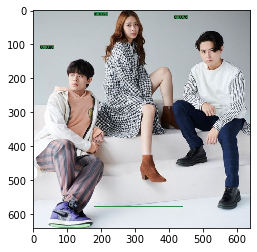

In [5]:
import time
yolo_anchor_path = "yolo_anchors1.txt"
fmaps = parse_model('structure/quan_data_224.txt', STRUCTURE)
# sys.exit()
image = cv2.imread("11.jpg")
# image = cv2.imread("/home/soc507/github/tflite/messi.jpg")
size = image.shape[:2]
img = image.copy()

if True:
    image = cv2.resize(image, (224,224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.transpose(2,0,1)
    t = time.time()
    outputs = [ fmap(image) for fmap in fmaps ]
    print(time.time() - t)

    for i, fm in enumerate(outputs):
        np.save(f"fm{i}", fm)
     
    # sys.exit()

outputs = [ np.load(f"fm{i}.npy") for i in range(3) ]

'''
qdata = parse_quantizedata('quan_data.txt')
outputs = [
    dequantize(
        np.load(f"/home/soc507/github/tflite/agilev3_gt/{141+i}-feature_map_{i+1}.txt.npy").squeeze().transpose(2,0,1),
        qdata[141+i]['zero'],
        qdata[141+i]['scale'],
    )
    for i in range(3)
]
'''

with open(yolo_anchor_path) as f:
    anchors = np.fromiter(map(int,f.readline().strip().split(",")), dtype=np.int)

anchors = anchors.reshape(3,3,2)

all_boxes = []
all_confs = []
all_probs = []

for fmap, anchor in zip(outputs, anchors[::-1]):
    _, boxes, confs, probs = reorg(fmap.transpose(1,2,0), anchor, size, 4)
    print(boxes.shape, confs.shape, probs.shape)
    all_boxes.append(np.column_stack((boxes[:,:2]-boxes[:,2:4]/2, boxes[:,:2]+boxes[:,2:4]/2)))
    all_confs.append(confs)
    all_probs.append(probs)

all_boxes = np.concatenate(all_boxes, axis=0)
all_confs = np.concatenate(all_confs, axis=0)
all_probs = np.concatenate(all_probs, axis=0)

boxes, scores, classes = cpu_nms(all_boxes, all_confs*all_probs, num_classes=4, score_thresh=0.5, iou_thresh=0.5)
print(boxes, scores, classes)

for box, score, cls in zip(boxes, scores, classes):
    plot_one_box(img, box, label=f"{cls}: {score:.2f}")

import matplotlib.pyplot as plt
cv2.imwrite("out_HW.png", img)
print(img[:,:,::-1].shape)
plt.imshow(img[:,:,::-1])
plt.show

(641, 640, 3)


<function matplotlib.pyplot.show(*args, **kw)>

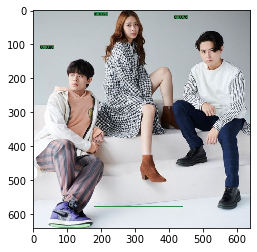

In [6]:
import matplotlib.pyplot as plt
cv2.imwrite("out_.png", img)
print(img[:,:,::-1].shape)
plt.imshow(img[:,:,::-1])
plt.show

In [7]:
import glob

# gt = glob.glob("girl_gt/*")
hw = glob.glob("girl_gt_HW/con_tmp_o/*")

for i in [2,5,38,41,44,47,50,53,56,59,8,11,14,17,20,23,26,29,32,35,74,77,109,120,123,126,141,131,134,137,80,83,86,89,142,94,97,100,103,106,112,115,143,]:
# for i in [2]:
    # print(i)
    path = f"girl_gt_HW/con_tmp_o/layer_{i}.npy"
    path_all = f"girl_gt_HW/all_out_o/{i}-conv.npy"
    a = np.load(path)
    b = np.load(path.replace("girl_gt_HW","girl_gt_SW"))
    c = np.load(path_all)
    d = np.load(path_all.replace("girl_gt_HW","girl_gt_SW"))

    assert a.shape == b.shape, f"should have same dimesion at axis 0, found {a.shape} vs {b.shape}"  
        
    p = path.split('/')[-1]
    x = a == b
    #y = np.bitwise_and(c == d, c != 0)
    y = c == d

    if False:
        fig = plt.gcf()
        fig.set_size_inches((21,10.5))
        for j in range(a.shape[0]):
            ax = plt.subplot(a.shape[0]/8, 8, j+1)
            m = np.ones((a.shape[1], a.shape[2], 3), dtype=np.uint8)*255
            m *= x[j][:,:,None]
            ax.imshow(m)
            
    print(f"the {i:3d} layer is {x.sum()/a.size*100:07.4f} %, ({a.min()},{a.max()}), ({b.min()},{b.max()}), {a.shape}")
#     print(f"the {i:3d} layer is {y.sum()/a.size*100:07.4f} %, ({c.min()},{c.max()}), ({d.min()},{d.max()}),")
#     print()

the   2 layer is 100.0000 %, (-58173,61016), (-58173,61016), (32, 224, 224)
the   5 layer is 100.0000 %, (-134610,79509), (-134610,79509), (64, 112, 112)
the  38 layer is 100.0000 %, (-45275,29362), (-45275,29362), (32, 112, 112)
the  41 layer is 100.0000 %, (-117684,83248), (-117684,83248), (64, 112, 112)
the  44 layer is 100.0000 %, (-105684,115601), (-105684,115601), (128, 56, 56)
the  47 layer is 100.0000 %, (-46486,49818), (-46486,49818), (64, 56, 56)
the  50 layer is 100.0000 %, (-137464,137765), (-137464,137765), (128, 56, 56)
the  53 layer is 100.0000 %, (-97514,111336), (-97514,111336), (64, 56, 56)
the  56 layer is 100.0000 %, (-86415,79089), (-86415,79089), (128, 56, 56)
the  59 layer is 100.0000 %, (-398443,390702), (-398443,390702), (256, 28, 28)
the   8 layer is 100.0000 %, (-62609,70125), (-62609,70125), (128, 28, 28)
the  11 layer is 100.0000 %, (-180169,186417), (-180169,186417), (256, 28, 28)
the  14 layer is 100.0000 %, (-119768,148708), (-119768,148708), (128, 28, 2

0.0
the  20 layer is 100.0000 %, (-678187,607629), (-678187,607629), (512, 14, 14)


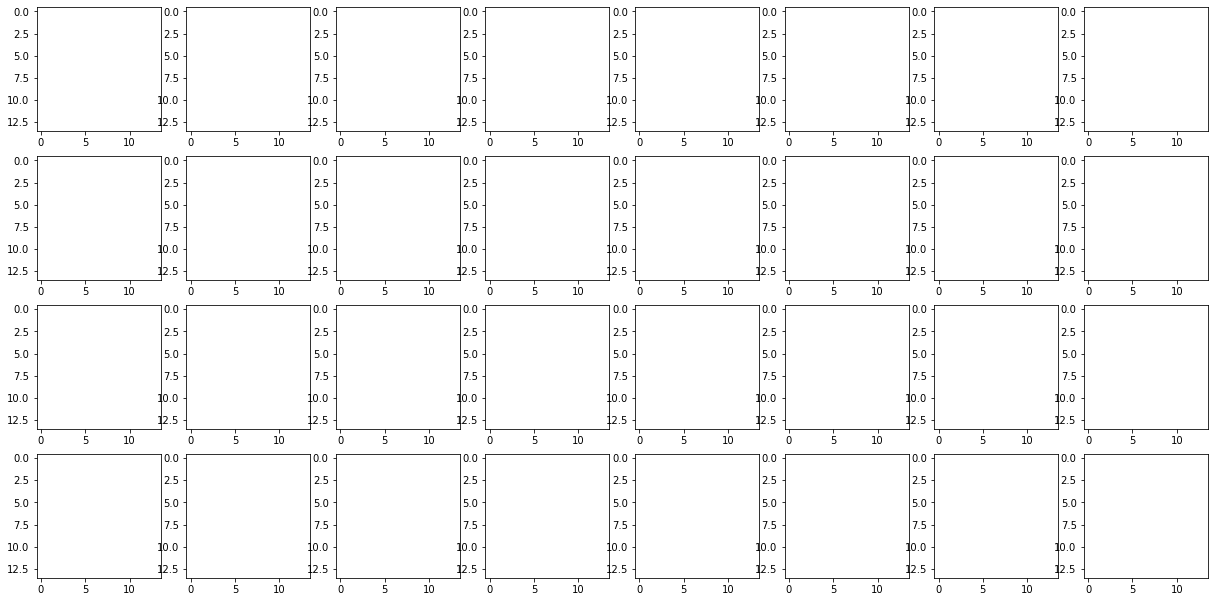

In [8]:
import glob

# gt = glob.glob("girl_gt/*")
hw = glob.glob("girl_gt_HW/con_tmp_o/*")

# for i in [2,5,38,41,44,47,50,53,56,59,8,11,14,17,20,23,26,29,32,35,74,77,109,120,123,126,141,131,134,137,80,83,86,89,142,94,97,100,103,106,112,115,143]:
for i in [20]:
    # print(i)
    path = f"girl_gt_HW/con_tmp_o/layer_{i}.npy"
    path_all = f"girl_gt_HW/all_out_o/{i}-conv.npy"
    a = np.load(path)
    b = np.load(path.replace("girl_gt_HW","girl_gt_SW"))
    c = np.load(path_all)
    d = np.load(path_all.replace("girl_gt_HW","girl_gt_SW"))

    assert a.shape == b.shape, f"should have same dimesion at axis 0, found {a.shape} vs {b.shape}"  
        
    p = path.split('/')[-1]
    x = a == b
    #y = np.bitwise_and(c == d, c != 0)
    y = c == d
       
    print((~x).sum()/64)

    if True:
        fig = plt.gcf()
        fig.set_size_inches((21,10.5))
        for j in range(32):
            ax = plt.subplot(4, 8, j+1)
            m = np.ones((a.shape[1], a.shape[2], 3), dtype=np.uint8)*255
            m *= x[j][:,:,None]
            ax.imshow(m)
            
    print(f"the {i:3d} layer is {x.sum()/a.size*100:07.4f} %, ({a.min()},{a.max()}), ({b.min()},{b.max()}), {a.shape}")
#     print(f"the {i:3d} layer is {y.sum()/a.size*100:07.4f} %, ({c.min()},{c.max()}), ({d.min()},{d.max()}),")
#     print()

In [9]:
import numpy as np
infm = np.load("/home/xilinx/jupyter_notebooks/infernce/girl_gt_SW/all_out_o/139-concat.npy")
win = np.load("/home/xilinx/jupyter_notebooks/infernce/agilev3_gt/agilev3_moon224_para/009-weights.txt.npy")
outhsfm = np.load("/home/xilinx/jupyter_notebooks/infernce/girl_gt_SW/con_tmp_o/layer_137.npy")
outhwfm = np.load("/home/xilinx/jupyter_notebooks/infernce/girl_gt_HW/con_tmp_o/layer_137.npy")
infmww = np.load("/home/xilinx/jupyter_notebooks/infernce/girl_gt_HW/all_out_o/139-concat.npy")

winww = np.load("/home/xilinx/jupyter_notebooks/infernce/agilev3_gt/agilev3_moon224_para/135-weights.txt.npy")

In [10]:
iferro  = infm - infmww
np.where(iferro != 0)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [11]:
#infm.shape
win.shape
#outhsfm.shape
#outhwfm.shape
#infmww.shape
#winww.shape

(128, 1, 1, 256)

In [12]:
win.shape

(128, 1, 1, 256)

In [13]:
a = infm
b = win
cs = outhsfm
ch = outhwfm

In [14]:
a[0:10,:,:]

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [ 48,  48,  22, ...,  28,  48,  48],
        ...,
        [ 29,  29,  25, ...,   5,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ..., 115,  31,  31],
        [  0,   0,   0, ..., 115,  31,  31],
        [ 16,  16,  25, ...,  28,  48,  48],
        ...,
        [  0,   0,   0, ...,  13,  17,  17],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[ 62,  62,  41, ...,  14,  27,  27],
        [ 62,  62,  41, ...,  14,  27,  27],
        [144, 144, 118, ...,  26,  79,  79],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [ 17,  17,   0, ...,   0,   0,   0],
        [ 17,  17,   0, ...,   0,   0,   0]],

       ...,

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  4,   4,   0, ...,   0,   0,   0

In [15]:
cnt=0
a[cnt:cnt+25,0:3,0:3]

array([[[  0,   0,   0],
        [  0,   0,   0],
        [ 48,  48,  22]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [ 16,  16,  25]],

       [[ 62,  62,  41],
        [ 62,  62,  41],
        [144, 144, 118]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 52,  52,   0],
        [ 52,  52,   0],
        [ 10,  10,   0]],

       [[154, 154,  28],
        [154, 154,  28],
        [  5,   5,   0]],

       [[ 58,  58,  19],
        [ 58,  58,  19],
        [ 84,  84,  22]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  4,   4,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [ 12,  12,   0]],

       [[183, 183,   9],
        [183, 183,   9],
        [ 37,  37,   0]],

       [[ 50,  50,   0],
        [ 50,  50,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [ 36,  36,  21]],

       [[  0,   0,   4],
        [  0,   0,   4],
        [ 81,  81,  28]],


In [16]:
cnt1 = 0
b[0,:,:,cnt1:cnt1+8]

array([[[113, 168, 134, 113, 154, 108, 151, 167]]], dtype=uint8)

In [17]:
bas = b.astype(int)-79
bas[0,:,:,cnt1:cnt1+8]

array([[[34, 89, 55, 34, 75, 29, 72, 88]]])

In [18]:
ce = cs- ch
np.where(ce != 0)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [19]:
Cs

NameError: name 'Cs' is not defined

In [ ]:
cs[113,:,:]

In [ ]:
ch[113,:,:]

In [ ]:
ce[65,:,:]

In [ ]:
np.where(bas == 33)